In [1]:
from math import ceil
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


In [2]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale = 0.1 # The scaling factor for the smallest anchor boxes
max_scale = 0.8 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = True # Whether or not you want to limit the boxes to lie entirely within the image boundaries
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `classifier_sizes` is needed below to set up `SSDBoxEncoder`
model, classifier_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios_global=aspect_ratios,
                                      aspect_ratios_per_layer=None,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes,
                                      coords=coords)
model.load_weights('./model_1_weights.h5')
#model = load_model('./model_0.h5')

In [3]:
### Set up training

batch_size = 32

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                classifier_sizes=classifier_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords)

# 5: Create the batch generator

batch_generator = BatchGenerator(images_path='./data/',
                                 labels_path='./data/labels.csv',
                                 n_classes=n_classes)

train_generator = batch_generator.generate(batch_size=batch_size,
                                           train=True,
                                           ssd_box_encoder=ssd_box_encoder,
                                           crop=False,
                                           resize=False,
                                           gray=False,
                                           equalize=False,
                                           brightness=(0.5, 2, 0.5),
                                           flip=0.5,
                                           translate=((5, 50), (3, 30), 0.5),
                                           scale=(0.75, 1.3, 0.5),
                                           limit_boxes=True,
                                           include_thresh=0.4,
                                           diagnostics=False)

n_samples = batch_generator.get_n_samples()

In [ ]:
### Run training

# 6: Run training

epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./model_2_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)])

model_name = 'model_2'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

In [4]:
### Make predictions

# 1: Create a generator to provide samples

predict_generator = batch_generator.generate(batch_size=1,
                                             train=False,
                                             crop=False,
                                             resize=False,
                                             gray=False,
                                             equalize=False,
                                             brightness=False,
                                             flip=False,
                                             translate=False,
                                             scale=False,
                                             limit_boxes=True,
                                             include_thresh=0.4,
                                             diagnostics=False)

In [5]:
X, y_true = next(predict_generator)

In [6]:
y_pred = model.predict(X)

In [7]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [8]:
print(y_pred.shape)

y_pred_converted = np.copy(y_pred[:,:,-9:-4]) # Slice out the four offset predictions plus one element where we'll write the class IDs in the next step
y_pred_converted[:,:,0] = np.argmax(y_pred[:,:,:-8], axis=-1)

print(np.sum(y_pred_converted[0,:,0]))

np.set_printoptions(suppress=True, precision=3)
print(y_pred[y_pred[:,:,1] > 0.5])

(1, 10316, 10)
58.0
[[   0.358    0.642    0.157    0.117    0.528   -0.277  194.483  141.429
    16.971   33.941]
 [   0.068    0.932    0.128    0.162    0.277    0.009  194.483  141.429
    24.      24.   ]
 [   0.007    0.993    0.138    0.161    0.002   -0.25   194.483  141.429
    33.941   33.941]
 [   0.169    0.831    0.117    0.223   -0.134    0.366  194.483  141.429
    33.941   16.971]
 [   0.084    0.916   -0.085    0.147    0.534   -0.276  202.759  141.429
    16.971   33.941]
 [   0.01     0.99    -0.055    0.202    0.201   -0.019  202.759  141.429
    24.      24.   ]
 [   0.001    0.999   -0.111    0.184   -0.089   -0.277  202.759  141.429
    33.941   33.941]
 [   0.04     0.96    -0.052    0.27    -0.022    0.431  202.759  141.429
    33.941   16.971]
 [   0.397    0.603    0.002    0.143   -0.502   -0.506  211.034  141.429
    24.      24.   ]
 [   0.457    0.543   -0.207    0.116   -0.07    -0.242  211.034  141.429
    33.941   33.941]
 [   0.105    0.895    0.128  

In [9]:
print(y_true[0])

[[  3  70 133 183   1]
 [ 59 167  86 189   1]
 [186 213 136 162   1]
 [216 230 139 151   1]
 [233 252 140 158   1]
 [302 335 140 157   1]
 [358 392 137 157   1]]


In [10]:
y_true_encoded = ssd_box_encoder.encode_y(y_true)

print(y_true_encoded[y_true_encoded[:,:,1] == 1].shape)
print(y_true_encoded[y_true_encoded[:,:,1] == 1])

(36, 10)
[[   0.       1.       0.154    0.149   -0.539   -0.693  219.31   141.429
    24.      24.   ]
 [   0.       1.      -0.046    0.164    0.002   -0.529  376.552  141.429
    33.941   33.941]
 [   0.       1.       0.266   -0.029    0.464   -0.267  194.483  150.
    16.971   33.941]
 [   0.       1.       0.188   -0.042    0.118    0.08   194.483  150.
    24.      24.   ]
 [   0.       1.       0.133   -0.029   -0.229   -0.267  194.483  150.
    33.941   33.941]
 [   0.       1.       0.133   -0.059   -0.229    0.427  194.483  150.
    33.941   16.971]
 [   0.       1.      -0.221   -0.029    0.464   -0.267  202.759  150.
    16.971   33.941]
 [   0.       1.      -0.157   -0.042    0.118    0.08   202.759  150.
    24.      24.   ]
 [   0.       1.      -0.111   -0.029   -0.229   -0.267  202.759  150.
    33.941   33.941]
 [   0.       1.      -0.111   -0.059   -0.229    0.427  202.759  150.
    33.941   16.971]
 [   0.       1.       0.181   -0.059   -0.58     0.059  235.862 

In [11]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.9)

In [12]:
print(y_pred_decoded)

[array([[ 181.727,  213.377,  133.205,  157.412,    1.   ,    0.932],
       [ 182.168,  216.161,  133.659,  160.096,    1.   ,    0.993],
       [ 186.843,  215.788,  133.545,  159.312,    1.   ,    0.916],
       [ 186.773,  216.106,  134.506,  158.047,    1.   ,    0.99 ],
       [ 183.454,  214.515,  134.805,  160.522,    1.   ,    0.999],
       [ 184.386,  217.586,  132.96 ,  159.075,    1.   ,    0.96 ],
       [ 230.627,  253.797,  136.882,  155.363,    1.   ,    0.992],
       [ 228.78 ,  254.001,  134.236,  155.06 ,    1.   ,    0.944],
       [ 183.541,  216.569,  134.666,  160.066,    1.   ,    0.998],
       [ 184.209,  216.302,  133.222,  158.245,    1.   ,    0.997],
       [ 186.782,  213.159,  135.161,  160.395,    1.   ,    0.998],
       [ 188.757,  214.691,  132.599,  158.679,    1.   ,    0.982],
       [ 185.149,  216.401,  134.658,  159.792,    1.   ,    1.   ],
       [ 185.526,  214.17 ,  133.488,  158.315,    1.   ,    0.999],
       [ 187.582,  213.718,  135.

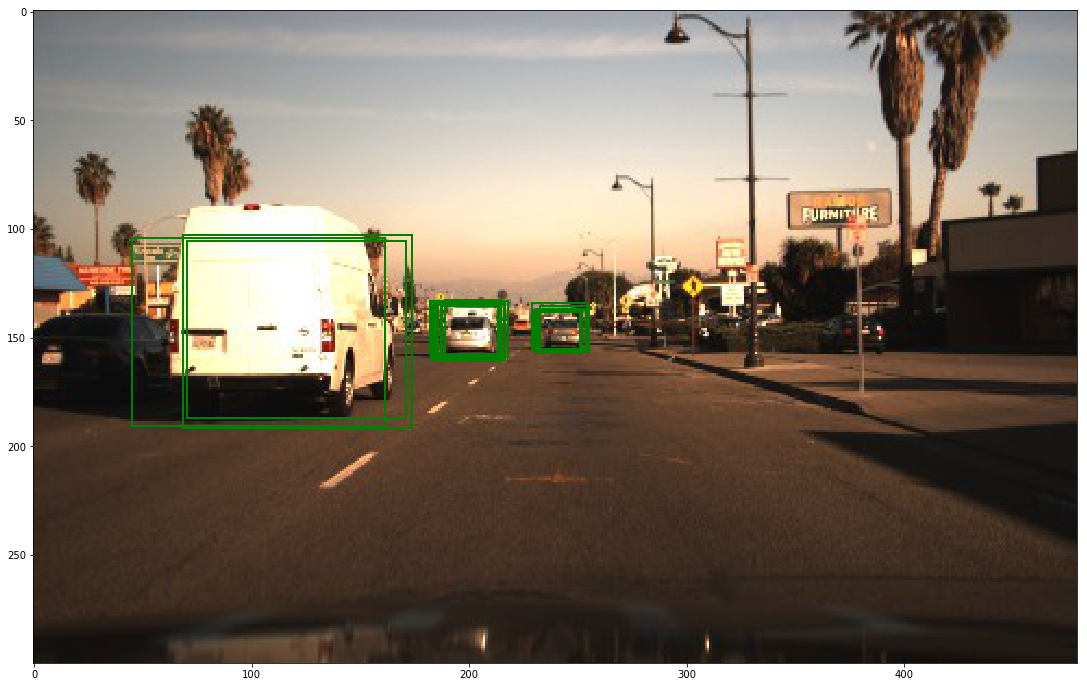

In [13]:
plt.figure(figsize=(20,12))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))

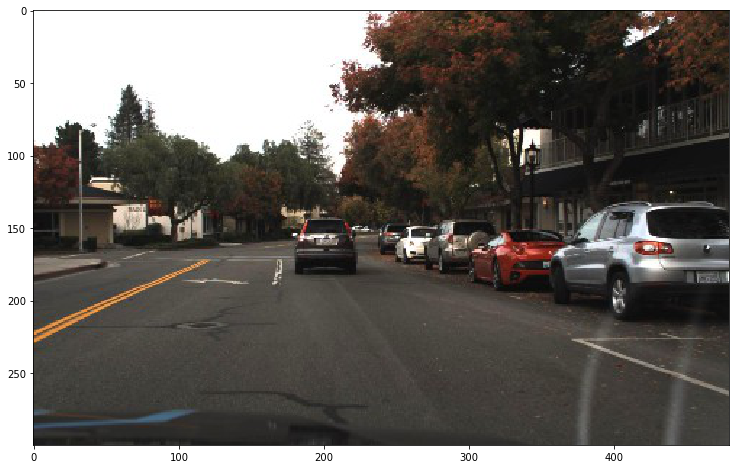

In [14]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

img = mpimg.imread("./data/1478900910256548477.jpg")

plt.figure(figsize=(16,8))
plt.imshow(img)